# Chignolin BG with "better" torsions

https://github.com/noegroup/bgflow/tree/michele

Preprocess the torsions. Separate them into:
- trivial torsions: the marginal is a Gaussian. Some are shifted, and some are folded (e.g. methyl)
- nontrivial torsions: ramachandran ($\phi$, $\psi$) and other. Uniform marginal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

import bgmol
import bgflow as bg
from bgflow.utils.types import assert_numpy

In [3]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [4]:
import mdtraj as md
import nglview as nv

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32
# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = {"device": device, "dtype": dtype}
ctx

{'device': device(type='cuda', index=0), 'dtype': torch.float32}

In [6]:
import os

temp = 301
is_data_here = os.path.isdir("ChignolinOBC2PT")
dataset = bgmol.datasets.ChignolinOBC2PT(download=not is_data_here, read=True, temperature=temp)
target = dataset.get_energy_model(n_workers=1)
model = dataset.system

Using downloaded and verified file: /tmp/parameters_ak_dihefix.prm
Using downloaded and verified file: /tmp/structure.pdb
Using downloaded and verified file: /tmp/structure.psf
Using downloaded and verified file: /tmp/top_all22star_prot.rtf
Using downloaded and verified file: /tmp/top_water_ions.rtf
Using downloaded and verified file: /tmp/chignolin_tica.npz


In [7]:
from matplotlib.colors import LogNorm
try:
    import fessa
    plt.set_cmap('fessa')
except:
    pass

def plot_cgn_traj(trajectory, w=None, get_tic1=False, cgn=model):
    tics = cgn.to_tics(trajectory, eigs_kept=2)
    plot_range = [[-2, 2], [-2, 4]]
    
    #histogram
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title("Histogram")
    plt.hist2d(tics[:,0], tics[:,1], 60, weights=w, norm=LogNorm(), range=plot_range)
    plt.xlim(plot_range[0])
    plt.ylim(plot_range[1])
    plt.xlabel("TIC1")
    plt.ylabel("TIC2")
    plt.gca().set_box_aspect(1)
    
    #trajectory
    plt.subplot(1,2,2)
    plt.title("Trajectory")
    end = len(tics[:,0])
    plt.scatter(range(end), tics[:,0], c=tics[:,1], s=10)
    plt.xlim([0, end])
    plt.xlabel("n_iter")
    plt.ylabel("TIC1")
    plt.colorbar()
    plt.gca().set_box_aspect(0.5)
    plt.show()
    
    if get_tic1:
        return tics[:,0]

def plot_tics(tics, title=None):
    fig, ax = plt.subplots(1,2, figsize=(7,4))
    fig.tight_layout(pad=1.0)
    if title is not None:
        fig.suptitle(title, y=1., fontsize=12)
    ax[0].set_xlim(-2, 2)
    ax[0].set_ylim(-2, 4)
    ax[0].set_xlabel("TIC1")
    ax[0].set_ylabel("TIC2")
    ax[0].hist2d(
        tics[:,0], tics[:,1], 
        bins=100, range=[[-2,2], [-2,4]], 
        density=True, norm=LogNorm()
    )
    ax[1].set_xlabel("TIC1")
    # y-axis on the right
    # ax1 = plt.twinx(ax[1])
    # ax[1].get_yaxis().set_visible(False)
    # ax1.set_ylabel("TIC2")
    sc = ax[1].scatter(tics[:,0], tics[:,1], s=0.7, c=tics[:,2], vmin=-1, vmax=0.5)
    plt.colorbar(sc, ax=ax[1], label="TIC3")
    plt.show()

def plot_ics(name, data, data2=None, data3=None, chosen=None):
    data = assert_numpy(data)
    if data2 is not None:
        data2 = assert_numpy(data2)
    if data3 is not None:
        data3 = assert_numpy(data3)
    if chosen is None:
        chosen = np.random.choice(range(len(data[0,:])))
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title(name+' %d of %d'%(chosen+1, len(data[0,:])))
    plt.plot(data[:,chosen], 'o')
    if data2 is not None:
        plt.plot(data2[:,chosen], 'o')
    if data3 is not None:
        plt.plot(data3[:,chosen], 'o')
    plt.subplot(1,2,2)
    plt.hist(data[:,chosen], bins=50, density=True, histtype='step', label='target')
    if data2 is not None:
        plt.hist(data2[:,chosen], bins=50, density=True, histtype='step', label='generated')
    if data3 is not None:
        plt.hist(data3[:,chosen], bins=50, density=True, histtype='step', label='prior')
    plt.legend()
    plt.show()

def plot_energies(bg_energies, md_energies):  
    max_bg_ene = np.percentile(bg_energies, 50)
    rangex = np.linspace(min(np.amin(md_energies), np.amin(bg_energies)), max(np.amax(md_energies), max_bg_ene), 75)
    plt.hist(bg_energies, bins=rangex, density=True, label="BG", histtype='step')
    plt.hist(md_energies, bins=rangex, density=True, label="MD", histtype='step')
    plt.xlabel("Energy   [$k_B T$]")
    plt.ylabel(f"Count   [#Samples / {len(samples)}]")
    plt.legend()
    plt.show()
    print('---')
    print(f'BG energy: min={np.amin(bg_energies):g} max={np.amax(bg_energies):g}')
    print(f'MD energy: min={np.amin(md_energies):g} max={np.amax(md_energies):g}')
    if np.amin(bg_energies) > np.amax(md_energies):
        print(' +++ NO OVERLAP! +++')
    print('---')

<Figure size 432x288 with 0 Axes>

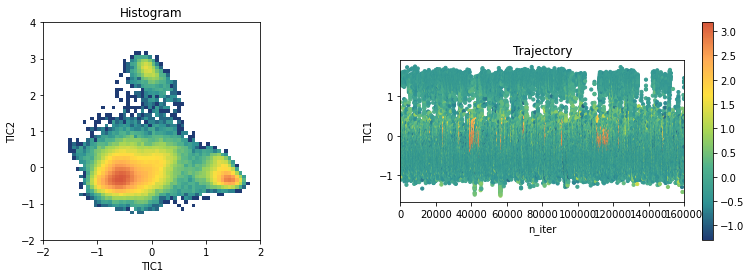

525 atoms
160000 data points


In [8]:
plot_cgn_traj(dataset.xyz)
n_atoms = model.positions.shape[0]*model.positions.shape[1]
print(n_atoms, 'atoms')
print(len(dataset.xyz), 'data points')

In [9]:
%%time
test_fraction = 6/16
n_test = int(len(dataset.xyz) * test_fraction)
n_train = len(dataset.xyz) - n_test
print(f'n_train = {n_train:_}')
print(f'n_test  =  {n_test:_}')

training_data = torch.as_tensor(dataset.xyz[:n_train], **ctx).view(n_train, n_atoms)
data_tics = model.to_tics(dataset.xyz[:n_train], eigs_kept=3)
testing_data = torch.as_tensor(dataset.xyz[n_train:], **ctx).view(n_test, n_atoms)

stored_energies_file = f'ChignolinOBC2PT/dataset_energies-T{temp}.npy'
if not os.path.exists(stored_energies_file):
    print('calculating energies...', end='\r')
    with torch.no_grad():
        data_ene = assert_numpy(target.energy(torch.as_tensor(dataset.xyz).view(-1, n_atoms)).view(-1))
    np.save(stored_energies_file, data_ene)

data_ene = np.load(stored_energies_file)[:n_train]
with torch.no_grad():
    few = 10
    assert torch.allclose(target.energy(training_data[:few]).view(-1), torch.as_tensor(data_ene[:few], **ctx), atol=5e-4), "energy mismatch!"

#shuffle all
rand_perm = torch.randperm(len(training_data))
training_data = training_data[rand_perm]
data_ene = data_ene[rand_perm]
data_tics = data_tics[rand_perm]

n_train = 100_000
n_test  =  60_000
CPU times: user 1.59 s, sys: 427 ms, total: 2.02 s
Wall time: 1.66 s


## Prepare IC transform

In [10]:
#get z_matrix and place phi and psi angles at the beginning
z_matrix = bgmol.ZMatrixFactory(model.mdtraj_topology).build_with_templates()[0]
is_ramachandran = bgmol.is_ramachandran_torsion(z_matrix, model.mdtraj_topology)
n_ramachandrans = is_ramachandran.sum()
print('Tot Ramachandran angles:', n_ramachandrans)

is_ramachandran[:3] = True #first three should remain at the start
z_matrix = np.vstack((z_matrix[is_ramachandran], z_matrix[~is_ramachandran]))

Tot Ramachandran angles: 18


In [11]:
FOLD_METHYL = True

#set if torsion is gaussian and if has to be shifted
with torch.no_grad():
    coordinate_transform = bg.GlobalInternalCoordinateTransformation(z_matrix)
    torsions_values = assert_numpy(coordinate_transform.forward(training_data)[2])
    if FOLD_METHYL:
        #set methyl groups. these are also trivial, but some are too uniform to be modelled as truncated gaussian
        is_methyl = bgmol.is_methyl_torsion(z_matrix, model.mdtraj_topology)
        torsions_values[:, is_methyl[3:]] = (torsions_values[:, is_methyl[3:]] % (1/3)) * 3 #fold the methyls
    n_torsions = torsions_values.shape[-1]

from scipy.stats import shapiro
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='p-value may not be accurate for N > 5000.')
    is_gaussian = np.full(n_torsions, False)
    is_tobe_shifted = np.full(n_torsions, False)
    for t in range(n_ramachandrans, n_torsions):
        pvalue = shapiro(torsions_values[:,t])[1]
        if pvalue > 0:
            is_gaussian[t] = True
        else:
            pvalue = shapiro((torsions_values[:,t]+0.5)%1)[1]
            if pvalue > 0:
                is_tobe_shifted[t] = True
is_gaussian = np.append(np.full(3, False), is_gaussian) #add first three anchor points
is_tobe_shifted = np.append(np.full(3, False), is_tobe_shifted) #add first three anchor points
is_trivial = is_gaussian + is_tobe_shifted
n_trivialt = (is_trivial).sum()

if FOLD_METHYL:
    print('Tot methyl:', is_methyl.sum(), 'of which', np.logical_and(is_trivial, is_methyl).sum(), 'are gaussian')
print('Tot Gaussian:', is_gaussian.sum())
print('Tot Gaussian-if-shifted:', is_tobe_shifted.sum())
print('Tot trivial torsions:', n_trivialt)
z_matrix = np.vstack((z_matrix[~is_trivial], z_matrix[is_gaussian], z_matrix[is_tobe_shifted]))

Tot methyl: 4 of which 2 are gaussian
Tot Gaussian: 57
Tot Gaussian-if-shifted: 67
Tot trivial torsions: 124


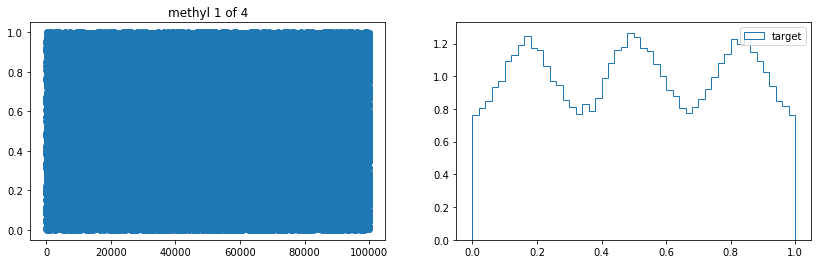

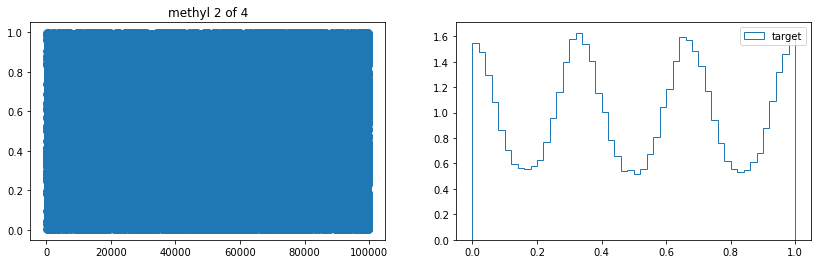

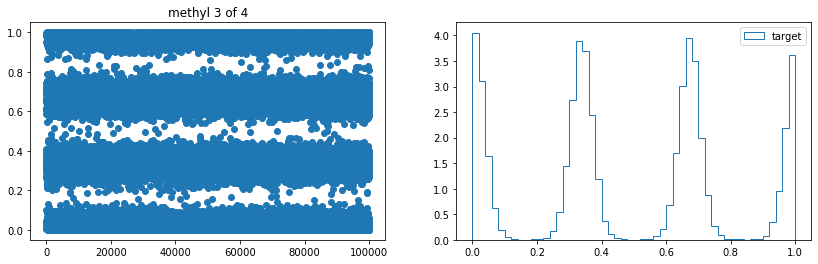

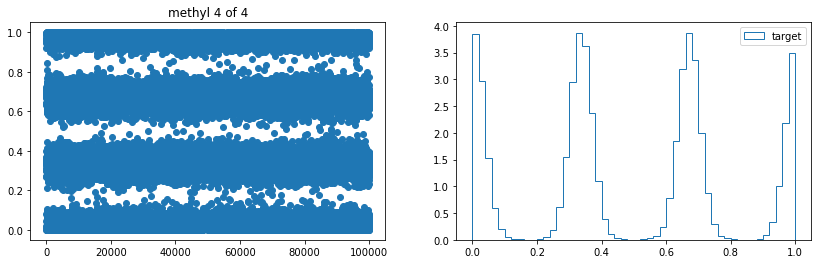

In [12]:
with torch.no_grad():
    coordinate_transform = bg.GlobalInternalCoordinateTransformation(z_matrix)
    torsions_values = coordinate_transform.forward(training_data)[2]
    type_torsion = 'methyl'
    selected_indices = np.argwhere(bgmol.is_type_torsion(type_torsion, z_matrix[3:], model.mdtraj_topology)).reshape(-1)
    mytorsions = torsions_values[:, selected_indices]
    for i in range(mytorsions.shape[-1]):
        plot_ics(type_torsion, mytorsions, chosen=i)

In [13]:
coordinate_transform = bg.GlobalInternalCoordinateTransformation(z_matrix).to(**ctx)
constrained_indices, constrained_lengths = bgmol.bond_constraints(
    model.system,
    coordinate_transform
)
shape_info = bg.ShapeDictionary.from_coordinate_transform(
    coordinate_transform, 
    n_constraints=len(constrained_indices)
)

torsions_shift = torch.zeros(n_torsions).to(**ctx)
torsions_shift[-is_tobe_shifted.sum():] = 0.5  #those to be shifted where placed at the end
prepareTorsions = bg.CircularShiftFlow(torsions_shift)

if FOLD_METHYL:
    is_methyl = bgmol.is_methyl_torsion(z_matrix[3:], model.mdtraj_topology)
    torsions_multiplicity = torch.ones(n_torsions).to(**ctx)
    torsions_multiplicity[is_methyl] = 3
    #double oxygens, manunally found by looking. these could also be identified with a is_type_torsion function
    torsions_multiplicity[n_ramachandrans+9] = 2
    torsions_multiplicity[n_ramachandrans+14] = 2
    prepareTorsions = bg.SequentialFlow([bg.CircularShiftFlow(torsions_shift), bg.IncreaseMultiplicityFlow(torsions_multiplicity)])    

from bgflow import TORSIONS, BONDS, ANGLES
n_torsions = shape_info[TORSIONS][0]
n_othert = n_torsions-n_ramachandrans-n_trivialt
# RAMACHANDRANS = bg.TensorInfo(name='RAMACHANDRANS', is_circular=True)
# OTHER_TORSIONS = bg.TensorInfo(name='OTHER_TORSIONS', is_circular=True)
NONTRIVIAL_TORSIONS = bg.TensorInfo(name='NONTRIVIAL_TORSIONS', is_circular=True)
TRIVIAL_TORSIONS = bg.TensorInfo(name='TRIVIAL_TORSIONS', is_circular=True)
shape_info.split(
    TORSIONS,
    into=(NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS),
    sizes=(n_ramachandrans + n_othert, n_trivialt)
)
shape_info

ShapeDictionary([(TensorInfo(name='BONDS', is_circular=False), (96,)),
                 (TensorInfo(name='ANGLES', is_circular=False), (173,)),
                 (TensorInfo(name='NONTRIVIAL_TORSIONS', is_circular=True),
                  (48,)),
                 (TensorInfo(name='TRIVIAL_TORSIONS', is_circular=True),
                  (124,))])

In [14]:
#build marginal for trivial torsions
with torch.no_grad():
    torsions_values = coordinate_transform.forward(training_data)[2]
    trivial_torsions_values = prepareTorsions(torsions_values)[0][:,-n_trivialt:]
        
trivial_torsions_marginal = bg.TruncatedNormalDistribution(
    mu=trivial_torsions_values.mean(axis=0),
    sigma=trivial_torsions_values.std(axis=0),
    lower_bound=torch.tensor(0),
    upper_bound=torch.tensor(1)
).to(**ctx)
with torch.no_grad():
    print(trivial_torsions_marginal.sample(1).shape)

torch.Size([1, 124])


In [15]:
#build the generator
builder = bg.BoltzmannGeneratorBuilder(shape_info, target, **ctx)
# builder.default_transformer_type = bg.MixtureCDFTransformer #smooth NF
RAMACHANDRANS, OTHER_TORSIONS = builder.add_split(
    NONTRIVIAL_TORSIONS, 
    into=["RAMACHANDRANS", "OTHER_TORSIONS"],
    sizes_or_indices=[n_ramachandrans, n_othert]
)
for i in range(3):
    PHI, PSI = builder.add_split(
        RAMACHANDRANS, 
        into=["PHI", "PSI"],
        sizes_or_indices=[np.arange(n_ramachandrans)[::2], np.arange(n_ramachandrans)[1::2]]
    )
    builder.add_condition(PHI, on=PSI)
    builder.add_condition(PSI, on=PHI)
    builder.add_merge([PHI, PSI], to=RAMACHANDRANS)
    R1, R2 = builder.add_split(
        RAMACHANDRANS, 
        into=["R1", "R2"],
        sizes_or_indices=[n_ramachandrans//2, n_ramachandrans//2]
    )
    builder.add_condition(R1, on=R2)
    builder.add_condition(R2, on=R1)
    builder.add_merge([R1, R2], to=RAMACHANDRANS)

T1, T2, T3 = builder.add_split(
    OTHER_TORSIONS, 
    into=["T1", "T2", "T3"],
    sizes_or_indices=[len(i) for i in np.array_split(np.arange(n_othert), 3)]
)
for i in range(4):
    builder.add_condition(T1, on=(T2,T3,RAMACHANDRANS))
    builder.add_condition(T2, on=(T1,T3,RAMACHANDRANS))
    builder.add_condition(T3, on=(T1,T2,RAMACHANDRANS))
builder.add_merge([T1, T2, T3, RAMACHANDRANS], to=NONTRIVIAL_TORSIONS)
for i in range(3):
    builder.add_condition(TRIVIAL_TORSIONS, on=(BONDS, ANGLES, NONTRIVIAL_TORSIONS))
    builder.add_condition(BONDS, on=(ANGLES, TRIVIAL_TORSIONS, NONTRIVIAL_TORSIONS))
    builder.add_condition(ANGLES, on=(BONDS, TRIVIAL_TORSIONS, NONTRIVIAL_TORSIONS))
cdfs = bg.InternalCoordinateMarginals(builder.current_dims, builder.ctx, torsions=NONTRIVIAL_TORSIONS)
cdfs.inform_with_data(training_data,
                      coordinate_transform,
                      constrained_bond_indices=constrained_indices,
                      torsions=None
                     )
cdfs[TRIVIAL_TORSIONS] = trivial_torsions_marginal
builder.add_map_to_ic_domains(cdfs)
builder.add_merge([NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS], to=TORSIONS)
builder.add_torsion_shifts(torsions_shift)
if FOLD_METHYL:
    builder.add_torsion_multiplicities(torsions_multiplicity)
builder.add_merge_constraints(constrained_indices, constrained_lengths)
builder.add_map_to_cartesian(coordinate_transform)

generator = builder.build_generator()

tot_param = np.sum([np.prod(p.size()) for p in generator.parameters()])
print(f"Number of Parameters: {tot_param:_}")

Number of Parameters: 5_661_327


## Visualize BG before training

Average dlogp: -1164.373779296875
 AbsMax dlogp: 1203.6326904296875


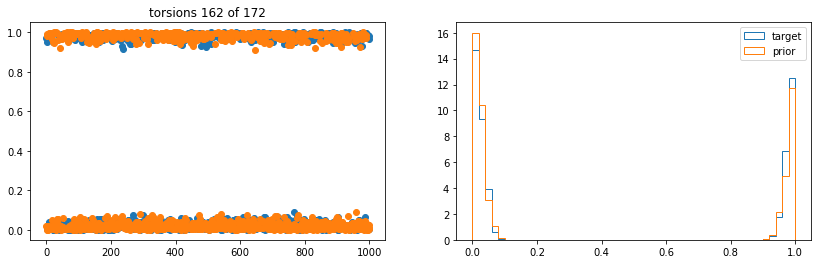

In [16]:
# visualize prior
with torch.no_grad():
    n_samples = 1_000 #len(training_data)//10
    samples, dlogp = generator.sample(n_samples, with_dlogp=True)
    *ics_m, dlogp2 = coordinate_transform.forward(samples)
    dlogp += dlogp2
    print('Average dlogp:', dlogp.mean().item())
    print(' AbsMax dlogp:', dlogp.abs().max().item())
    ics_t = coordinate_transform.forward(training_data[:n_samples])
    l = 2
    title = ['bonds', 'angles', 'torsions', 'fixed', '???', 'dlogp']
    # for i in range(ics_t[l].shape[1]):
    #     plot_ics(title[l], ics_t[l], data3=ics_m[l], chosen=i)
    plot_ics(title[l], ics_t[l], data3=ics_m[l])
    del samples, dlogp, ics_t, ics_m

In [17]:
%%time

n_samples = 10_000
batch = 1000
samples = []
log_weights = []
dlogp = []
for i in range(n_samples // batch):
    print(f'sampling... {i*batch/n_samples:.0%}', end='\r')
    with torch.no_grad():
        tmp_samples, tmp_dlogp, tmp_log_weights = generator.sample(batch, with_log_weights=True, with_dlogp=True)
        tmp_samples = tmp_samples.cpu()
        tmp_dlogp = tmp_dlogp.cpu()
        tmp_log_weights = tmp_log_weights.cpu()
    samples.append(tmp_samples)
    dlogp.append(tmp_dlogp)
    log_weights.append(tmp_log_weights)
samples = torch.cat(samples, dim=0)
dlogp = assert_numpy(torch.cat(dlogp, dim=0).view(-1))
log_weights = torch.cat(log_weights, dim=0).view(-1)
print('calculating energies...', end='\r')
samples_ene = assert_numpy(target.energy(samples))


CPU times: user 5min 8s, sys: 20.1 s, total: 5min 28s
Wall time: 55.4 s


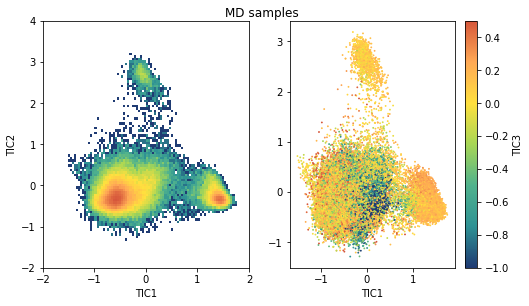

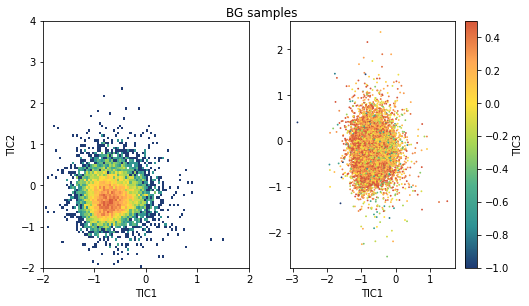

Effective sample size: 1
  Sampling efficiency: 1.000000e-04



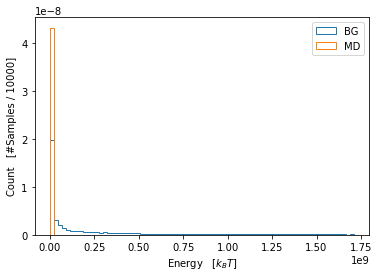

---
BG energy: min=2048.97 max=1.67066e+26
MD energy: min=-100.326 max=77.3389
 +++ NO OVERLAP! +++
---


In [18]:
with torch.no_grad():
    plot_tics(data_tics, 'MD samples')
    plot_tics(model.to_tics(samples.view(n_samples, -1, 3), eigs_kept=3).numpy(), 'BG samples')

    ESS = bg.effective_sample_size(log_weights)
    print('Effective sample size: %g' % ESS)
    print('  Sampling efficiency: %e' % (ESS/len(log_weights)))
    print('')
    plot_energies(samples_ene, data_ene)

## NLL Training

In [19]:
optim = torch.optim.Adam(generator.parameters(), lr=1e-3)

from torch.utils.data import DataLoader, TensorDataset
trainloader = DataLoader(
    TensorDataset(training_data),
    batch_size=128, shuffle=True
)
valloader = DataLoader(
    TensorDataset(testing_data),
    batch_size=512, shuffle=False
)

running_average = 0.0
tau = 100
reporter = [np.nan] #save some time by not calculating initial NLL
test_reporter = []
with torch.no_grad():
    test_nll = 0
    counter = 0
    for batch, in tqdm(valloader, leave=False):
        nll_batch = generator.energy(batch.to(**ctx)).mean().item()
        counter += 1
        test_nll += (nll_batch - test_nll) / counter
    print(f'Initial validation NLL: {test_nll:.2f}')
    test_reporter.append(test_nll)

  0%|          | 0/118 [00:00<?, ?it/s]

Initial validation NLL: -1380.54


In [20]:
%%time

N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    # Training
    for batch, in tqdm(trainloader, leave=False):
        optim.zero_grad()
        nll = generator.energy(batch.to(**ctx)).mean()
        nll.backward()
        optim.step()
        nll = nll.item()
        running_average += (nll - running_average) / tau
        print(f"\rEpoch {epoch+1}/{N_EPOCHS}"   
              f"     NLL {nll:.2f}",  
              f"     Running Av. {running_average:.2f}",
              end="")
        reporter.append(nll)
    
    # Validation
    with torch.no_grad():
        test_nll = 0.0
        counter = 0
        print("   Validation ...", end="")
        for batch, in valloader:
            nll_batch = generator.energy(batch.to(**ctx)).mean().item()
            # update mean
            counter += 1
            test_nll += (nll_batch - test_nll) / counter
        print(f"  NLL {test_nll: .2f}")
        test_reporter.append(test_nll)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/10     NLL -1461.52      Running Av. -1453.55   Validation ...  NLL -1453.74


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/10     NLL -1456.11      Running Av. -1459.46   Validation ...  NLL -1457.07


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/10     NLL -1462.47      Running Av. -1462.35   Validation ...  NLL -1458.31


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/10     NLL -1463.81      Running Av. -1464.56   Validation ... -1464.87  NLL -1458.93


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/10     NLL -1470.60      Running Av. -1466.43   Validation ...  NLL -1459.39


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/10     NLL -1466.61      Running Av. -1467.91   Validation ...  NLL -1459.42


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/10     NLL -1471.21      Running Av. -1469.61   Validation ...  NLL -1459.58


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/10     NLL -1471.51      Running Av. -1471.25   Validation ...  NLL -1459.69


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/10     NLL -1476.58      Running Av. -1472.79   Validation ... -1474.04  NLL -1460.00


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/10     NLL -1471.68      Running Av. -1473.92   Validation ...  NLL -1459.96
CPU times: user 27min 39s, sys: 7.33 s, total: 27min 47s
Wall time: 23min 40s


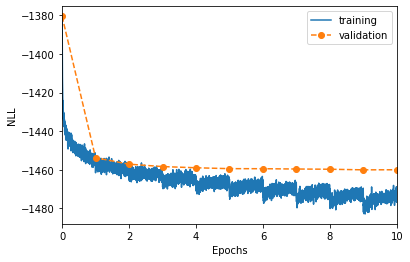

In [21]:
it = np.arange(len(reporter)) / (len(reporter)-1) * (len(test_reporter)-1)
plt.plot(it, reporter, label='training')
plt.plot(test_reporter, '--o', label='validation')
# plt.ylim(np.nanmin(reporter), test_reporter[1])
plt.xlim(0, max(it))
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [22]:
# #setup training
# nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
# nll_trainer = bg.KLTrainer(
#     generator,
#     optim=nll_optimizer,
#     train_energy=False
# )

In [23]:
# %%time
# #run training
# nll_trainer.train(
#     n_iter=4000,
#     data=training_data,
#     # testdata=testing_data,
#     batchsize=2**7,
#     n_print=100, 
# )

In [24]:
# plt.plot(nll_trainer.reporter._raw[-1]) #TODO: better reporter
# plt.show()

## Visualize Generator

In [25]:
%%time

n_samples = 10_000
batch = 100
samples = []
log_weights = []
for i in range(n_samples // batch):
    print(f'sampling... {i*batch/n_samples:.0%}', end='\r')
    with torch.no_grad():
        tmp_samples, tmp_log_weights = generator.sample(batch, with_log_weights=True)
        tmp_samples = tmp_samples.cpu()
        tmp_log_weights = tmp_log_weights.cpu()
    samples.append(tmp_samples)
    log_weights.append(tmp_log_weights)
samples = torch.cat(samples, dim=0)
log_weights = torch.cat(log_weights, dim=0).view(-1)
print('calculating energies...', end='\r')
samples_ene = assert_numpy(target.energy(samples))


CPU times: user 6min 7s, sys: 20 s, total: 6min 28s
Wall time: 1min 7s


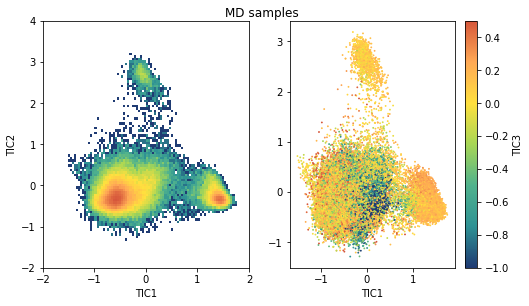

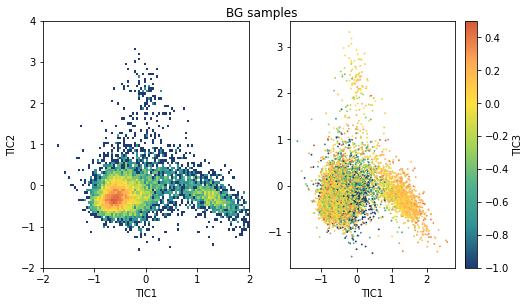

Effective sample size: 1.32059
Sampling efficiency: 1.320587e-04



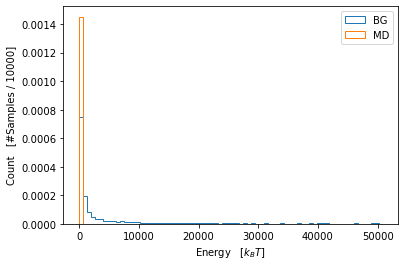

---
BG energy: min=26.4074 max=4.36061e+26
MD energy: min=-100.326 max=77.3389
---


In [26]:
with torch.no_grad():
    plot_tics(data_tics, 'MD samples')
    plot_tics(model.to_tics(samples.view(n_samples, -1, 3), eigs_kept=3).numpy(), 'BG samples')

    ESS = bg.effective_sample_size(log_weights)
    print('Effective sample size: %g' % ESS)
    print('Sampling efficiency: %e' % (ESS/len(log_weights)))

    print('')
    plot_energies(samples_ene, data_ene)

The worst 10 configurations, by energy
[4.3606103e+26 4.5444903e+24 3.0933734e+24 6.9510300e+22 2.4693772e+21
 8.1683060e+20 4.1593540e+20 1.0185967e+19 8.0352761e+18 7.5583794e+18]


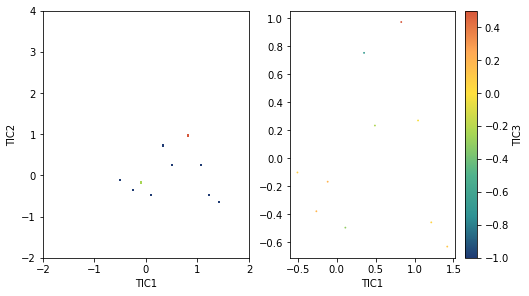

NGLWidget(max_frame=9)

In [27]:
frame_num = 10
bad_configs = assert_numpy(samples)[np.flip(np.argsort(samples_ene.reshape(-1)))]
traj = md.Trajectory(
    bad_configs[:frame_num].reshape(-1,len(model.positions),3),
    topology=model.mdtraj_topology
)

print(f'The worst {frame_num} configurations, by energy')
print(np.flip(np.sort(samples_ene.reshape(-1)))[:frame_num])

plot_tics(model.to_tics(bad_configs[:frame_num]))

view = nv.show_mdtraj(traj)
# view.add_representation('ball+stick')
view.add_representation('licorice')
view

In [28]:
raise SystemError('Stop here for now')

SystemError: Stop here for now

## Energy training

In [ ]:
%%time
#setup training
nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
nll_trainer = bg.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=True
)

#run energy training
nll_trainer.train(
    n_iter=1000,
    data=training_data,
    # testdata=testing_data,
    batchsize=2**7,
    n_print=100, 
    w_energy=0.01,
)

In [ ]:
%%time

n_samples = 10_000
batch = 100
samples = []
log_weights = []
for i in range(n_samples // batch):
    print(f'sampling... {i*batch/n_samples:.0%}', end='\r')
    with torch.no_grad():
        tmp_samples, tmp_log_weights = generator.sample(batch, with_log_weights=True)
        tmp_samples = tmp_samples.cpu()
        tmp_log_weights = tmp_log_weights.cpu()
    samples.append(tmp_samples)
    log_weights.append(tmp_log_weights)
samples = torch.cat(samples, dim=0)
log_weights = torch.cat(log_weights, dim=0).view(-1)
print('calculating energies...', end='\r')
samples_ene = assert_numpy(target.energy(samples))


In [ ]:
with torch.no_grad():
    plot_tics(data_tics, 'MD samples')
    plot_tics(model.to_tics(samples.view(n_samples, -1, 3), eigs_kept=2).numpy(), 'BG samples')

    ESS = bg.bg.effective_sample_size(log_weights)
    print('Effective sample size: %g' % ESS)
    print('Sampling efficiency: %e' % (ESS/len(log_weights)))
    print('')
    plot_energies(samples_ene, data_ene)

In [ ]:
traj = md.Trajectory(
    samples[::100].view(-1,len(model.positions),3).numpy(),
    topology=model.mdtraj_topology
)

view = nv.show_mdtraj(traj)
view.add_representation('ball+stick')
view